https://medium.com/@amit25173/k-means-clustering-vs-gaussian-mixture-bec129fbe844

https://scikit-learn.org/stable/modules/mixture.html



# Sentinel-1 Data

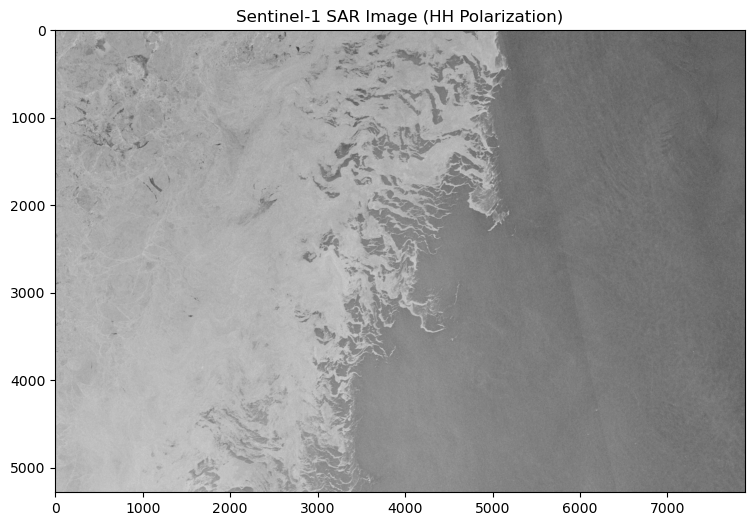

In [1]:
import rasterio
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

# Read the Sentinel-1 data
file_path = 'subset_3_of_S1A_EW_GRDM_1SDH_20240405T211859_20240405T211959_053304_067647_844B_Bdr_tnr_Spk_Cal_dB_TC.tif'
with rasterio.open(file_path) as src:
    sar_image = src.read(1)  # Reading the first band (HH polarization)
    width, height = src.width, src.height

# plot the Sentinel-1 HH band img
plt.figure(figsize=(10, 6))
plt.imshow(sar_image, cmap='gray')
plt.title('Sentinel-1 SAR Image (HH Polarization)')
plt.show()

# Extract a 500x500 pixel subset from the center of the image
subset_size = 500
center_x, center_y = width // 2, height // 2
start_x, start_y = center_x - subset_size // 2, center_y - subset_size // 2
subset_image = sar_image[start_y:start_y + subset_size, start_x:start_x + subset_size]

# Convert the image to float32 for accurate computation
subset_image = subset_image.astype(np.float32)


# K-means

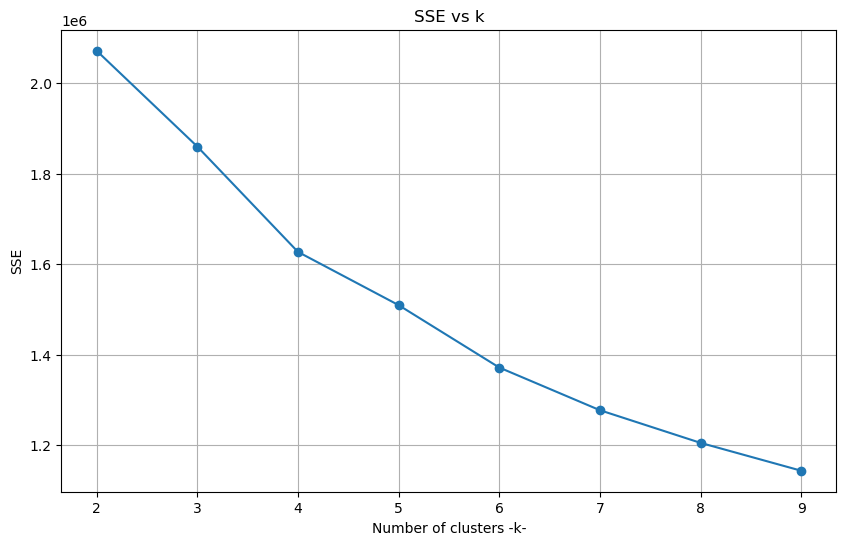

Sum of squared error is 2071814.625 2 number of clusters k-mean
Sum of squared error is 1860076.0 3 number of clusters k-mean
Sum of squared error is 1627276.25 4 number of clusters k-mean
Sum of squared error is 1509621.875 5 number of clusters k-mean
Sum of squared error is 1371691.5 6 number of clusters k-mean
Sum of squared error is 1277365.0 7 number of clusters k-mean
Sum of squared error is 1205177.875 8 number of clusters k-mean
Sum of squared error is 1143612.5 9 number of clusters k-mean


In [2]:
# Perform k-means clustering on subset image
import warnings # Ignore harmless warnings
warnings.filterwarnings("ignore")

#Experiment with different values of k.
k_val = list(range(2,10)) #k values btw 1 to 9
sse_val = []
for k in k_val:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(subset_image)
    sse_val.append(kmeans.inertia_) #adding values to the list of Sum of squared error (SSE)

# Create a plot of the sum of the squared error vs. k for determining the ideal k value.
plt.figure(figsize=(10, 6))
plt.plot(k_val, sse_val, marker='o')
plt.xlabel('Number of clusters -k-')
plt.ylabel('SSE')
plt.title('SSE vs k')
plt.grid(True)
plt.show()

for i in range(len(k_val)): #printing sse and k values
    print('Sum of squared error is', sse_val[i], k_val[i], 'number of clusters k-mean')
    


In [3]:
# Apply K-means clustering
# Reshape the image to a 2D array of pixels and corresponding values
rows, cols = subset_image.shape
sar_image_2d = subset_image.reshape(rows * cols, 1)

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=0).fit(sar_image_2d) #it looks clusters number is 4, due to elbow of the SSE vs k figure
classified_image = kmeans.labels_.reshape(rows, cols)


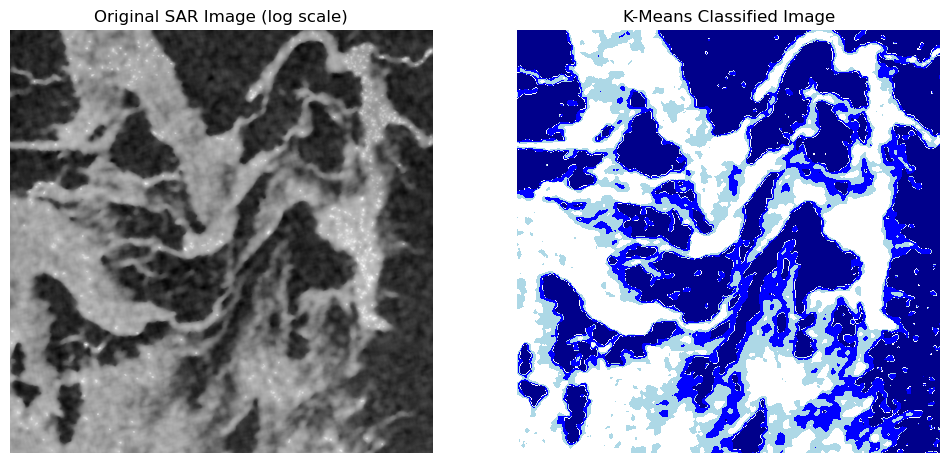

In [4]:
from matplotlib.colors import ListedColormap

# Plot the original and classified images

#special colors for each class
colors = ['darkblue', 'white', 'lightblue', 'blue']
cmap1 = ListedColormap(colors)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(subset_image, cmap='gray')
ax[0].set_title('Original SAR Image (log scale)')
ax[0].axis('off')

ax[1].imshow(classified_image, cmap=cmap1)
ax[1].set_title('K-Means Classified Image')
ax[1].axis('off')
plt.show()

# save the classified image
plt.imsave('k-means.png', classified_image, cmap=cmap1)


# GMM (Gaussian Mixture Models)

Number of culusters: 2, BIC Score: 1192843.09
Number of culusters: 3, BIC Score: 1175831.29
Number of culusters: 4, BIC Score: 1175912.66
Number of culusters: 5, BIC Score: 1175447.66
Number of culusters: 6, BIC Score: 1170687.91
Number of culusters: 7, BIC Score: 1170870.83
Number of culusters: 8, BIC Score: 1171049.90
Number of culusters: 9, BIC Score: 1171128.06


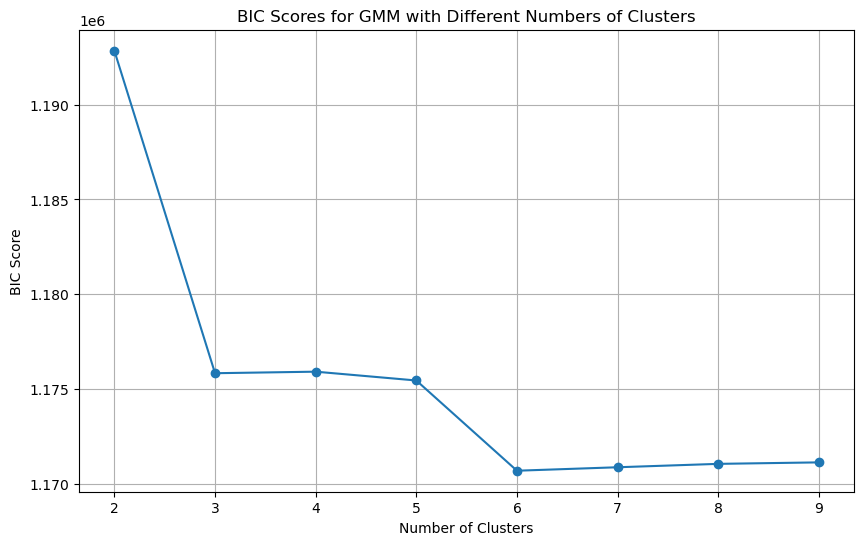

In [5]:
from sklearn.mixture import GaussianMixture

# Reshape the image data for GMM
pixels = subset_image.reshape(-1, 1) #flatten the image into a 2D array (number of pixels, 1 feature)

# Fit GMMs with different numbers of components and calculate BIC
n_components_range = range(2, 10)  #testing from 2 to 10 components
bic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(pixels)
    bic_scores.append(gmm.bic(pixels))
    print(f'Number of culusters: {n_components}, BIC Score: {gmm.bic(pixels):.2f}')

# plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC Score')
plt.title('BIC Scores for GMM with Different Numbers of Clusters')
plt.grid(True)
plt.show()


In [6]:
# Apply GMM classification
n = 3  # it seems 3 or 6 is the elbow based on the figure. but the improvement in 6 is not very big, so I chose 3
gmm = GaussianMixture(n_components = n, covariance_type='full', random_state=42)
gmm.fit(pixels)

# Predict the cluster for each pixel
clusters = gmm.predict(pixels)

# Reshape the cluster labels back into the original image dimensions
clustered_image = clusters.reshape(subset_image.shape)


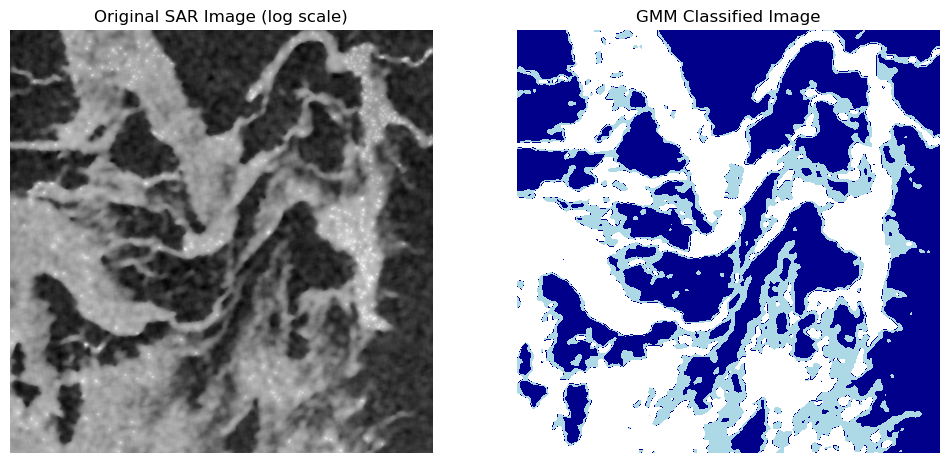

In [13]:
from matplotlib.colors import ListedColormap

# Plot the original and classified images

#special colors for each class
colors = ['white', 'darkblue', 'lightblue']
cmap2 = ListedColormap(colors)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(subset_image, cmap='gray')
ax[0].set_title('Original SAR Image (log scale)')
ax[0].axis('off')

ax[1].imshow(clustered_image, cmap=cmap2)
ax[1].set_title('GMM Classified Image')
ax[1].axis('off')
plt.show()

# save the classified image
plt.imsave('gmm.png', clustered_image, cmap=cmap2)


# Compare

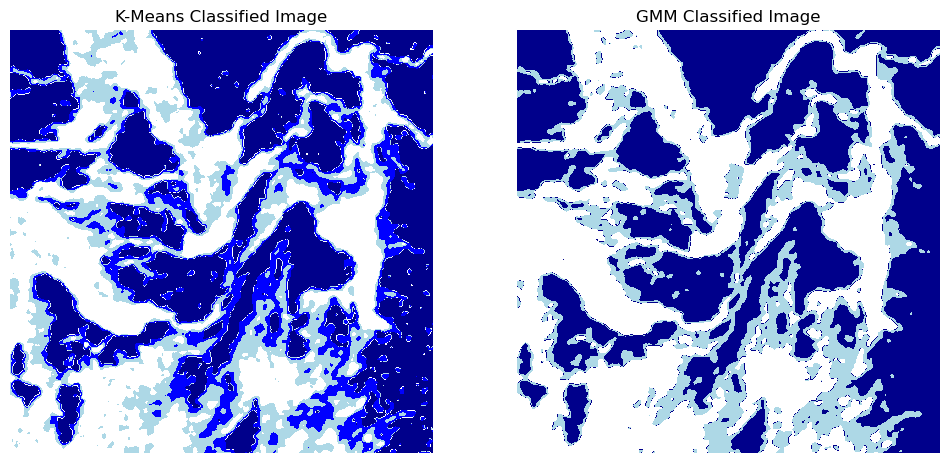

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(classified_image, cmap=cmap1)
ax[0].set_title('K-Means Classified Image')
ax[0].axis('off')

ax[1].imshow(clustered_image, cmap=cmap2)
ax[1].set_title('GMM Classified Image')
ax[1].axis('off')
plt.show()
